<a href="https://colab.research.google.com/github/dartwinshu/dibimbing-introduction-to-machine-learning/blob/main/Dibimbing%20-%20Introduction%20to%20Machine%20Learning%20-%20Part%2002%20(Clustering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Load Package

In [19]:
# install yellowbrick untuk visualisasi klaster dan mencari klaster optimal
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import numpy as np # untuk manipulasi objek array dan fungsi aritmatika lainnya
import pandas as pd # untuk menipulasi objek dataframe
import matplotlib.pyplot as plt # untuk visualisasi data
import seaborn as sns # untuk visualisasi data yang jauh lebih mudah

# untuk melakukan standarisasi pada data numerik
from sklearn.preprocessing import StandardScaler
# untuk pemodelan k-means
from sklearn.cluster import KMeans
# untuk mereduksi dimensi
from sklearn.decomposition import PCA
# untuk visualisasi elbow method
from yellowbrick.cluster import KElbowVisualizer
# untuk visualisasi silhouette score
from yellowbrick.cluster import SilhouetteVisualizer
# untuk mencari klaster optimal
from yellowbrick.cluster import KElbowVisualizer

# Load Dataset

In [21]:
raw_data = pd.read_csv("https://bit.ly/customer_segmentation_bank_dataset")

In [22]:
# cek dataset
raw_data.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


## Informasi terkait dataset

Dataset berikut adalah sekumpulan data yang dikumpulkan dari berbagai wilayah di USoleh sebuah bank yang terdiri dari profil nasabah dan beberapa metrik terkait kegiatan nasabah. Bank ingin memasarkan sebuah layanan terbaru yang diharapkan dapat digunakan oleh nasabah lama. Namun sebelum memasarkan mereka ingin mengetahui profil customer yang akan menjadi target pemasaran. Beberapa variabel yang digunkan dalam analisis diantaranya:

- Customer ID
- Age
- Edu
- Years
- Income
- Card Debt
- Other Debt
- Defaulted
- Address
- Debt Income Ratio

# Data Inspection & Preprocessing

In [23]:
# cek struktur data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          850 non-null    object 
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB


In [24]:
# cek apakah ada dataset yang hilang
raw_data.isna().sum()

Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
Address              0
DebtIncomeRatio      0
dtype: int64

In [25]:
# mengecek data yang hilang
raw_data[raw_data['Defaulted'].isna()]

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
5,6,40,1,23,81,0.998,7.831,NaN,NBA016,10.9
8,9,26,1,5,18,0.575,2.215,NaN,NBA006,15.5
11,12,34,2,9,40,0.374,0.266,NaN,NBA003,1.6
13,14,46,1,6,30,1.415,3.865,NaN,NBA019,17.6
15,16,24,1,1,16,0.185,1.287,NaN,NBA005,9.2
...,...,...,...,...,...,...,...,...,...,...
818,819,35,2,0,35,2.383,1.957,NaN,NBA006,12.4
820,821,37,1,4,24,0.419,2.989,NaN,NBA010,14.2
825,826,32,2,12,116,4.027,2.585,NaN,NBA011,5.7
835,836,21,3,0,41,2.367,5.628,NaN,NBA001,19.5


Ketika ada nilai yang hilang pada dataset maka sebelum ada perlakuan tertentu untuk mengatasi masalah nilai yang hilang tersebut, diantaranya perlu diketahui apakah:

1. Data hilang secara acak, yaitu kasus dimana data yang hilang diketahui sebabnya dan hilangnya data terjadi secara acak. Sebagai contoh beberapa baris data yang memiliki nilai null pada sensor dikarenakan listrik tidak stabil sehingga data tidak terbaca secara teratur.
2. Data hilang secara tidak acak, yaitu kasus dimana nilai yang hilang pada data diketahui sebabnya dan tidak terjadi secara acak, biasanya karena disebabkan oleh variabel atau kejadian tertentu. Sebagai contoh, terdapat data bernilai null pada variabel total pembayaran karena pelanggan adalah pelanggan baru yang belum membayar tagihan apapun.
3. Data hilang secara acak sebenar-benarnya, yaitu kasus dimana data yang hilang tidak diketahui sama sekali sebab hilangnya dan hal ini terjadi secara acak. 

Pada kasus di atas kita mengasumsikan bahwa data hilang secara acak sebenar-benarnya. Pada kasus ini kita bisa memilih antara membuang data tersebut atau melakukan imputasi pada data. Namun, kita akan memilih untuk membuang data untuk menyederhanakan pengerjaan.

In [26]:
# membuang nilai null dari raw_data
raw_data = raw_data[raw_data["Defaulted"].isna() == False]

In [27]:
# cek kembali nilai null pada raw_data
raw_data.isna().sum()

Customer Id        0
Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
Address            0
DebtIncomeRatio    0
dtype: int64

Selanjutnya kita akan melakukan preprocessing pada data

In [28]:
# membuang variabel 'Address'
raw_data = raw_data.drop('Address', axis = 1)

# menjadikan customer id sebagai index
raw_data = raw_data.set_index('Customer Id')

# cek kembali raw_data
raw_data.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,
1,41,2,6,19,0.124,1.073,0.0,6.3
2,47,1,26,100,4.582,8.218,0.0,12.8
3,33,2,10,57,6.111,5.802,1.0,20.9
4,29,2,4,19,0.681,0.516,0.0,6.3
5,47,1,31,253,9.308,8.908,0.0,7.2


Selanjutnya melakukan scaling pada semua data bernilai numerik.

In [29]:
# lakukan scaling pada data
data_for_model = StandardScaler().fit_transform(raw_data)

In [30]:
# cek data_for_model
data_for_model

array([[ 0.76830405,  0.29879269, -0.35900652, ..., -0.60428433,
        -0.59494973, -0.58052847],
       [ 1.51908977, -0.77932527,  2.64702891, ...,  1.5706204 ,
        -0.59494973,  0.37222169],
       [-0.23274357,  0.29879269,  0.24220057, ...,  0.83520125,
         1.68081427,  1.55949495],
       ...,
       [-1.2337912 ,  2.45502862, -1.26081715, ...,  0.04620852,
         1.68081427,  3.39170678],
       [-0.35787453, -0.77932527,  0.54280411, ..., -0.71904138,
        -0.59494973, -1.07889008],
       [ 2.14474454, -0.77932527,  1.1440112 , ...,  0.17648972,
        -0.59494973, -0.24340149]])

# Modeling

Membuat model K-means

In [31]:
# menentukan jumlah kelompok data yang akan dibentuk
num_clusters = 3

# fit k-means model pada data
k_means = KMeans(n_clusters=num_clusters, random_state = 1000)
k_means.fit(data_for_model)

# label cluster
labels = k_means.labels_

# cek labels
print(labels)

[2 1 0 2 1 2 2 1 0 2 0 2 2 2 2 0 1 1 2 2 2 2 1 0 2 0 0 2 0 1 0 1 2 2 2 1 1
 0 0 0 0 2 2 2 1 2 1 1 2 2 2 0 2 0 2 2 2 2 2 2 2 1 2 0 1 1 0 0 2 2 0 0 2 2
 0 2 0 2 0 0 1 2 2 2 2 0 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2
 2 2 1 2 0 2 2 2 0 2 2 1 0 0 1 2 2 2 2 2 2 2 2 1 2 2 0 2 0 2 2 0 1 0 2 2 1
 0 1 2 2 1 0 2 2 1 1 2 1 0 2 0 2 1 2 0 2 2 2 0 0 2 0 1 2 2 2 2 1 2 0 1 2 2
 2 1 2 0 1 2 2 2 2 2 1 2 2 2 2 2 1 0 2 0 2 2 2 0 1 0 1 2 2 0 2 2 0 0 0 2 2
 2 2 1 1 2 2 1 2 2 0 2 2 0 2 0 1 2 2 2 2 0 2 1 0 2 2 2 2 2 0 0 1 2 1 2 2 0
 0 2 2 2 1 0 2 2 0 2 1 2 2 2 0 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 0 2 0 2 2 2
 1 1 2 0 2 1 0 0 2 2 0 2 2 2 2 1 2 1 2 2 2 2 1 2 0 2 1 2 2 2 0 2 2 1 0 1 2
 2 2 0 0 2 0 1 2 1 2 1 2 0 2 2 1 0 2 1 2 2 2 1 2 2 2 2 1 0 2 2 2 2 1 0 2 2
 1 2 0 2 1 2 1 2 2 2 2 2 2 2 1 1 2 1 2 0 2 2 2 0 0 2 2 2 2 2 1 0 0 2 1 2 2
 2 0 1 0 0 0 0 2 2 0 2 0 0 2 0 1 2 0 2 0 1 1 2 0 2 0 0 0 2 2 1 2 0 2 2 0 2
 0 2 2 2 0 2 1 2 1 2 1 2 0 2 2 2 0 0 2 2 1 2 2 1 2 0 2 0 2 0 0 0 1 0 2 2 0
 2 2 2 1 0 0 2 2 2 2 2 0 

# Post-Modeling Analysis

In [32]:
# membuat kolom 'cluster' pada raw_data
raw_data['cluster'] = labels

# cek raw_data
raw_data.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,cluster
Customer Id,,,,,,,,,
1,41,2,6,19,0.124,1.073,0.0,6.3,2
2,47,1,26,100,4.582,8.218,0.0,12.8,1
3,33,2,10,57,6.111,5.802,1.0,20.9,0
4,29,2,4,19,0.681,0.516,0.0,6.3,2
5,47,1,31,253,9.308,8.908,0.0,7.2,1


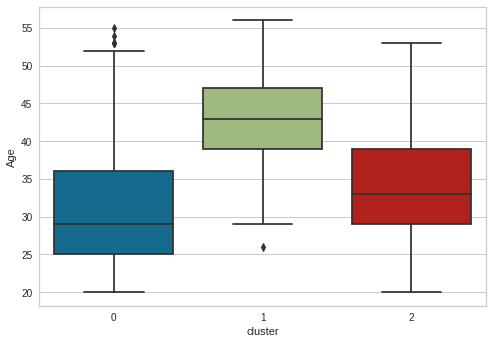

In [33]:
# mengecek distribusi age dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Age')

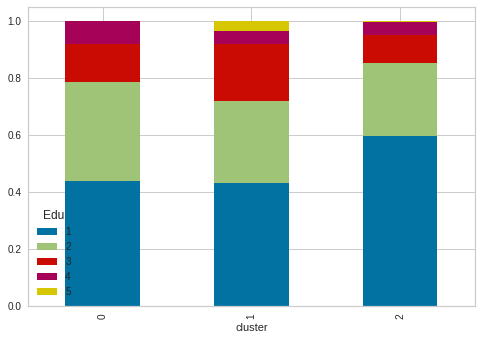

In [34]:
# mengecek distribusi Edu dari tiap cluster
raw_data.groupby('cluster')['Edu'].value_counts(normalize=True).unstack('Edu').plot.bar(stacked=True)

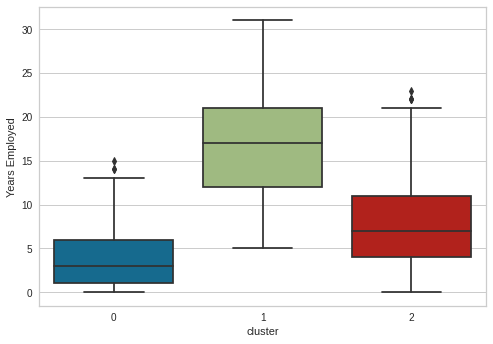

In [35]:
# mengecek distribusi Years Employed dari tiap klaster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Years Employed')

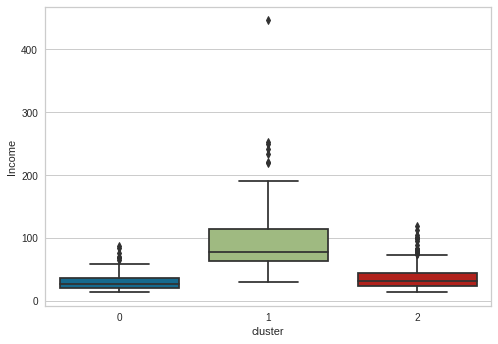

In [36]:
# mengecek distribusi Income dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Income')

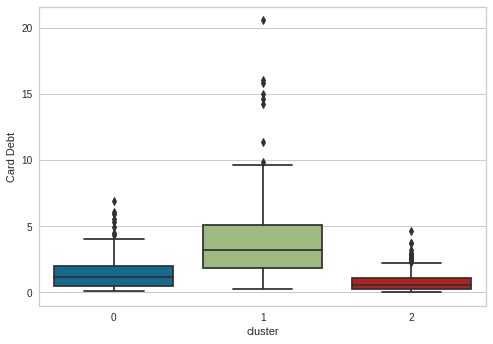

In [37]:
# mengecek distribusi Card Debt dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Card Debt')

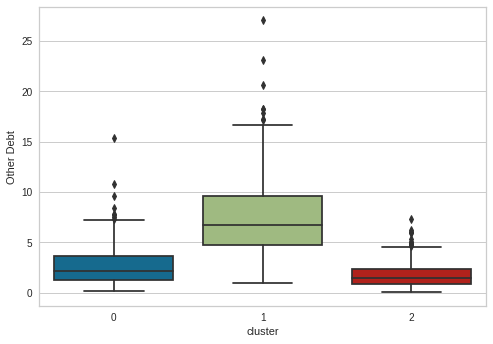

In [38]:
# mengecek distribusi Card Debt dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Other Debt')

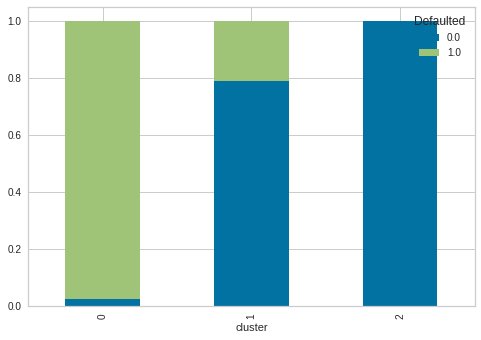

In [39]:
# mengecek distribusi Defaulted dari tiap cluster
raw_data.groupby('cluster')['Defaulted'].value_counts(normalize=True).unstack('Defaulted').plot.bar(stacked=True)

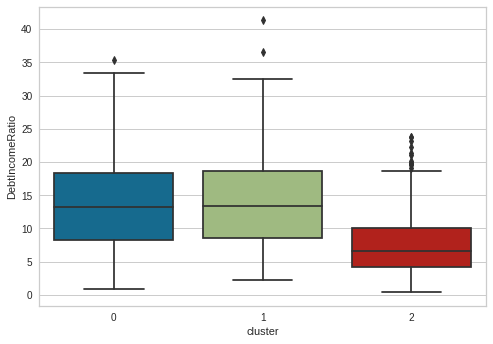

In [40]:
# mengecek distribusi Defaulted dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'DebtIncomeRatio')

# Evaluasi Model

Untuk evaluasi model clustering kita dapat menggunakan average silhouette score

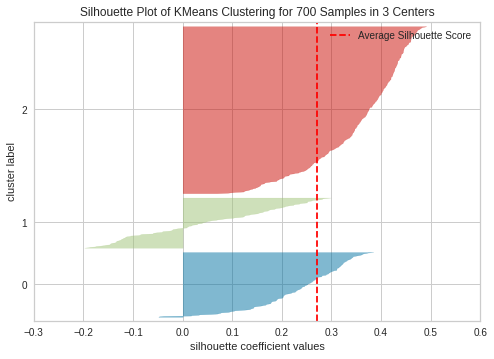

In [41]:
visualizer = SilhouetteVisualizer(k_means, colors='yellowbrick')
visualizer.fit(data_for_model)
visualizer.show()

Mencari klaster optimal dengan Elbow Method

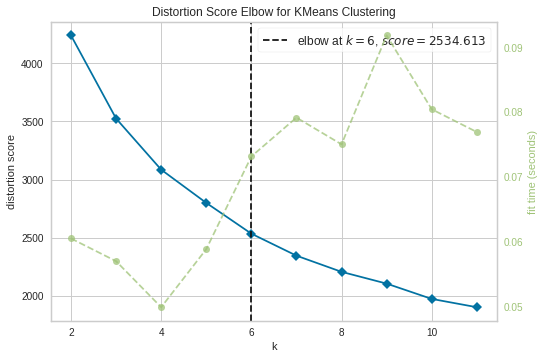

In [42]:
# Evaluasi model menggunakan decision tree
visualizer = KElbowVisualizer(k_means, k=(2,12))
visualizer.fit(data_for_model)
visualizer.show()

In [43]:
# menentukan jumlah kelompok data yang akan dibentuk
num_clusters = 6

# fit k-means model pada data
k_means_optimal = KMeans(n_clusters=num_clusters, random_state = 1000)
k_means_optimal.fit(data_for_model)

# label cluster
labels = k_means_optimal.labels_

# cek labels
print(labels)

[0 5 5 0 4 0 2 1 2 0 3 0 2 0 2 3 1 5 0 1 0 1 5 3 0 3 3 0 3 5 5 2 0 0 0 1 5
 3 5 3 3 2 1 1 1 1 1 5 0 0 1 3 0 3 2 2 1 0 0 0 0 5 1 5 1 1 3 3 1 0 3 3 2 0
 3 2 3 1 3 3 5 0 0 1 1 2 0 3 0 0 5 0 0 0 2 1 0 0 0 0 0 1 1 0 2 0 2 1 3 3 0
 0 0 5 2 3 0 0 0 3 0 1 1 3 3 5 1 0 0 2 2 0 0 2 5 0 2 3 0 3 1 0 3 1 3 0 0 4
 3 5 0 0 5 3 1 0 1 4 2 1 3 0 3 0 1 1 2 0 0 0 3 3 1 3 1 0 2 0 0 5 0 2 1 0 0
 5 5 0 3 5 0 0 1 0 1 1 2 0 2 0 0 1 3 1 3 0 0 5 2 5 3 5 0 1 3 0 0 3 3 3 0 0
 1 0 1 1 0 1 5 0 0 5 0 0 3 0 2 5 1 2 0 0 3 0 5 3 0 0 0 0 1 3 3 5 0 5 0 1 3
 3 1 1 1 5 3 0 2 3 0 1 1 2 1 3 5 0 0 2 0 0 4 2 1 0 0 0 5 2 0 1 3 0 2 2 0 1
 2 1 1 3 0 1 3 3 0 1 3 0 0 2 0 5 0 1 0 0 0 0 5 1 5 0 1 0 0 0 3 0 0 5 3 5 0
 1 5 3 3 1 3 5 1 5 0 1 0 3 2 0 5 3 2 5 0 0 0 5 1 1 1 0 4 3 0 0 1 0 5 3 2 0
 5 0 3 0 5 2 4 0 0 0 2 2 0 1 5 1 1 1 1 3 1 0 0 3 2 1 0 0 0 5 5 3 3 0 5 0 1
 0 3 4 3 3 3 3 2 1 3 1 3 3 2 3 4 1 3 0 3 5 5 2 3 2 3 3 3 0 5 4 0 3 0 0 3 0
 3 1 1 1 3 0 1 0 5 2 1 0 3 0 1 0 3 3 1 0 5 0 0 4 0 3 0 2 0 3 3 1 5 2 1 1 5
 0 0 0 5 3 3 0 1 1 0 1 3 

Evaluasi kembali model menggunakan silhouette score

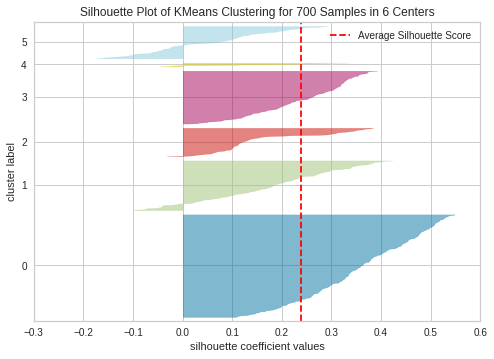

In [44]:
visualizer = SilhouetteVisualizer(k_means_optimal, colors='yellowbrick')
visualizer.fit(data_for_model)
visualizer.show()

Bandingkan dengan model sebelumnya

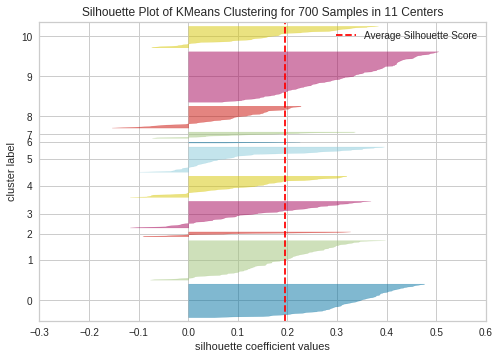

In [45]:
visualizer = SilhouetteVisualizer(k_means, colors='yellowbrick')
visualizer.fit(data_for_model)
visualizer.show()

Lakukan post-modeling analysis kembali berdasarkan model optimal

In [46]:
# membuat kolom 'cluster' pada raw_data
raw_data['cluster'] = labels

# cek raw_data
raw_data.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,cluster
Customer Id,,,,,,,,,
1,41,2,6,19,0.124,1.073,0.0,6.3,0
2,47,1,26,100,4.582,8.218,0.0,12.8,5
3,33,2,10,57,6.111,5.802,1.0,20.9,5
4,29,2,4,19,0.681,0.516,0.0,6.3,0
5,47,1,31,253,9.308,8.908,0.0,7.2,4


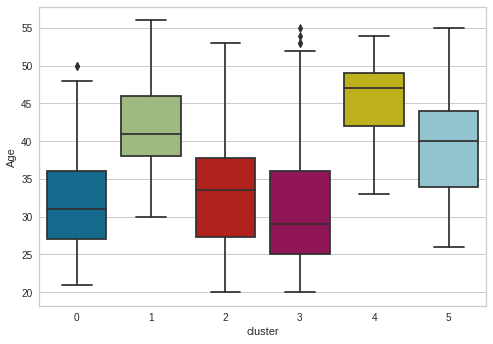

In [47]:
# mengecek distribusi age dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Age')

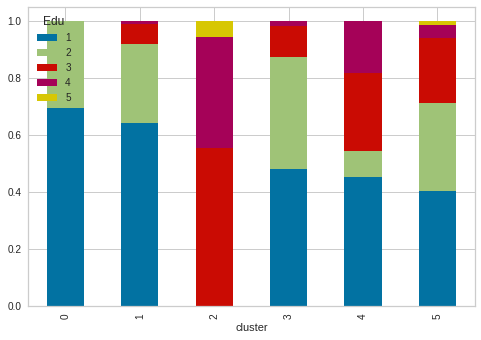

In [48]:
# mengecek distribusi Edu dari tiap cluster
raw_data.groupby('cluster')['Edu'].value_counts(normalize=True).unstack('Edu').plot.bar(stacked=True)

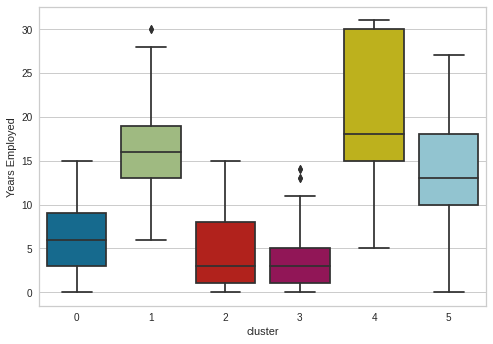

In [49]:
# mengecek distribusi Years Employed dari tiap klaster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Years Employed')

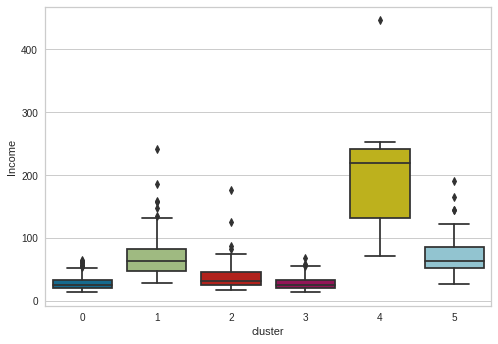

In [50]:
# mengecek distribusi Income dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Income')

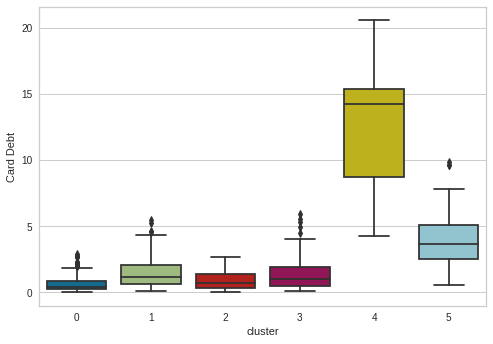

In [51]:
# mengecek distribusi Card Debt dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Card Debt')

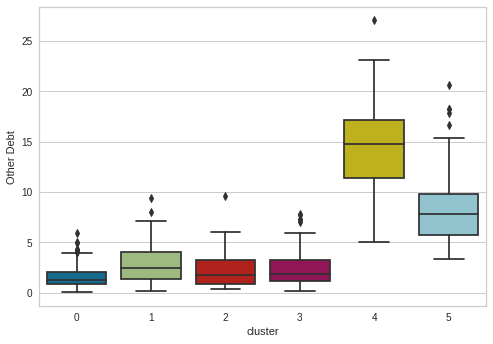

In [52]:
# mengecek distribusi Card Debt dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'Other Debt')

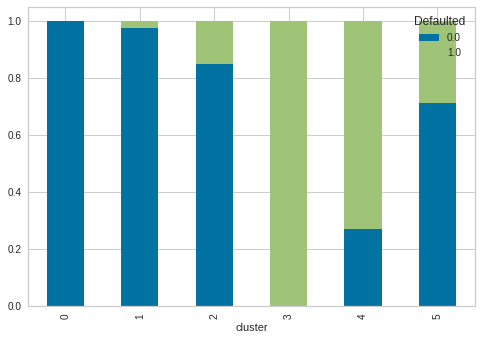

In [53]:
# mengecek distribusi Defaulted dari tiap cluster
raw_data.groupby('cluster')['Defaulted'].value_counts(normalize=True).unstack('Defaulted').plot.bar(stacked=True)

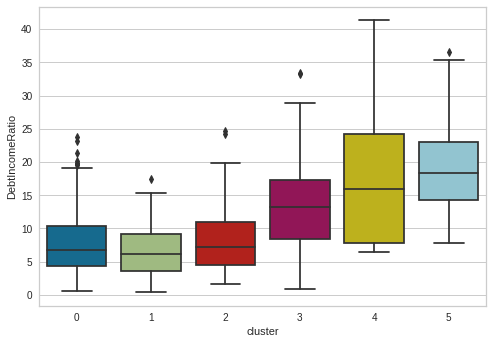

In [54]:
# mengecek distribusi Defaulted dari tiap cluster
sns.boxplot(data = raw_data, x = 'cluster', y = 'DebtIncomeRatio')